Code for "AI-driven high-throughput droplet screening of cell-free gene expression"
by Yang Shuo

### import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

### read data

In [3]:
data = pd.read_csv("task_1.csv",header=None)

### Print the first five lines
** Column 0 ** : Average value  
** Column 1 ** : Standard deviation  
** Columns 2-13 ** : Combine one-hot encoding

In [4]:
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,11888.280700,2475.410484,1,1,1,1,1,1,1,1,...,8960,9216,4864,9984,9984,10240,10240,10496,10496,10496
1,9635.495798,2840.493753,1,1,1,0,1,1,1,1,...,4864,4864,5888,4864,5120,5120,5120,5632,5632,5888
2,9732.196721,3965.244098,1,1,1,1,0,1,1,1,...,5632,5632,9984,5888,5888,5888,6144,6144,6400,6400
3,12901.052630,2003.605855,1,1,1,1,1,0,1,1,...,9728,9984,15104,9984,10240,10496,10496,10752,11008,11520
4,15669.132080,2356.119414,1,1,1,1,1,1,0,1,...,13824,15104,9216,17920,14848,15872,12288,12544,13056,13568


### Assign data
Normalized GFP, divided by the maximum value

In [5]:
data = np.array(data)
data_y = (data[:,0]/np.max(data[:,0])).reshape(-1,1)
data_x = data[:,2:14]
print("data_x:",data_x.shape)
print("data_y:",data_y.shape)

data_x: (100, 12)
data_y: (100, 1)


In [6]:
np.max(data[:,0])

16053.67742

In [7]:
print(data_x[0])
print(data_y[0])
np.save("data_y.npy",data_y)
np.save("data_x.npy",data_x)

[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
[0.74053317]


### Divide the data set randomly

In [8]:
X_train,X_val,y_train,y_val = train_test_split(data_x, 
                                               data_y, 
                                               test_size=0.3)

### Build model

In [9]:
def get_1d_model():
    model = Sequential()
    model.add(layers.Input(shape=(12,)))
    model.add(layers.Dense(32))
    model.add(layers.Dense(32, activation = "relu"))
    model.add(layers.Dense(16, activation = "relu"))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(16, activation = "tanh"))
    model.add(layers.Dense(8, activation = "tanh"))
    model.add(layers.Dense(8, activation = "tanh"))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1))

    model.compile(optimizer="adam",loss="mape")
    return model

### Training

In [10]:
model = get_1d_model()
epochs = 5000
history = model.fit(X_train, y_train, 
                    shuffle=True,
                    batch_size = 100,
                    epochs=epochs,
                    validation_data = (X_val, y_val),
                    verbose=0)

### Draw training history

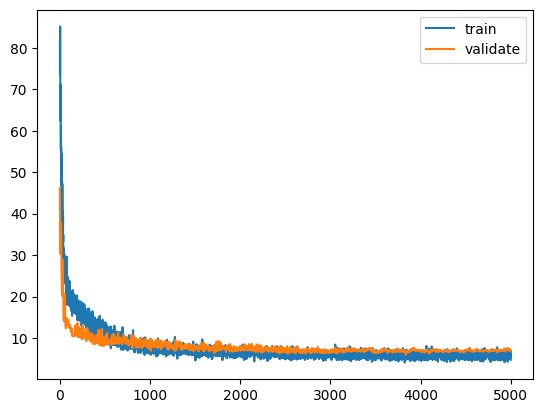

In [11]:
loss_history = history.history["loss"]
vall_history = history.history["val_loss"]
plt.plot(range(epochs), loss_history, label="train")
plt.plot(range(epochs), vall_history, label="validate")
plt.legend()

In [13]:
#### 保存模型
model.save("method2_1.h5")

In [14]:
#### 加载模型
model = load_model("method2_1.h5")

### Visualization of model predictive power

Text(0, 0.5, 'Prediction')

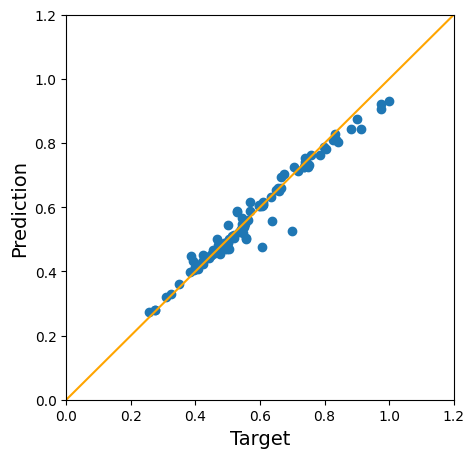

In [15]:
validation = model.predict(data_x)
plt.figure(figsize=(5,5))
plt.scatter(data_y[:,0], validation[:,0])
plt.plot([0,1.2], [0,1.2], color="orange")
plt.ylim((0,1.2))
plt.xlim((0,1.2))
plt.xlabel("Target",fontsize=14)
plt.ylabel("Prediction",fontsize=14)

In [16]:
df = np.concatenate([data_y[:,0].reshape((-1,1)), validation[:,0].reshape((-1,1))], axis=1)
df = pd.DataFrame(df)
df.to_csv("prediction_r2.csv")

### Interpretation function
real: Used to define the required input constraints, referring to the method of adding the energy supply material 
inp: All combination cases that satisfy the input constraint  
write_opt_tocsv: Writes prediction results to an excel file  

In [17]:
def _real_(comb):
    sum_1 = np.sum(comb[0:3])
    sum_2 = np.sum(comb[3:7])
    sum_3 = np.sum(comb[7:])
    
    if (sum_1 == 1) and (sum_2 == 1) and (sum_3 == 1):
        return True
    else:
        return False
inp = []
for i in range(4096):
    combination = bin(i)[2:]
    if len(combination) < 12:
        add = "0" * (12-len(combination))
        c = list(add + combination)
        c = np.array(list(c)).astype("int")#.reshape((-1,1))
    else:
        c = list(combination)
        c = np.array(list(c)).astype("int")#.reshape((-1,1))
    
    if _real_(c) is True:
        inp.append(c)
        
def write_opt_tocsv(y_opt, name):
    df = pd.DataFrame(np.array(y_opt))
    df.to_csv(name)
    
inp = np.array(inp)
inp.shape

(60, 12)

### Enumerate all available combinations and predict the score
Output the highest score and corresponding combinations

In [18]:
y_opt = model.predict(inp)
print(inp[np.argmax(y_opt)])
print(np.max(y_opt))

[1 0 0 1 0 0 0 1 0 0 0 0]
0.9323717


### Write prediction results to excel file

In [19]:
write_opt_tocsv(y_opt,"Opt_opt_2.11.csv")